In [121]:
import numpy as np
import tables as tb
import matplotlib.pyplot as plt
import neogeodb.hdf_orthophoto as himg
from matplotlib.ticker import MultipleLocator, FixedLocator
import mercantile
import neogeo.extent as neoextent
import time
import neogeodb.pytables_db as pdb
import matplotlib.animation as animation
from matplotlib.ticker import MultipleLocator, FixedLocator


%matplotlib inline

In [3]:
def plot_on_grid(tx, ty, val, xbounds, ybounds, fill=None):
    grid_shape = (ybounds[1] - ybounds[0], xbounds[1] - xbounds[0])
    grid_shape = np.abs(grid_shape) + 1
    img = np.zeros(grid_shape)
    if fill is not None:
        img[:, :] = fill
    img[ty - ybounds[0], tx - xbounds[0]] = val
    return img

def unpair(z):
    fsz = np.floor(np.sqrt(z))
    if z - fsz**2 < fsz:
        return z-fsz**2, fsz
    else:
        return np.int(fsz), np.int(z - fsz**2 - fsz)

In [4]:
def pad_grid(xbounds, ybounds):
    # Get Database Quadrants
    xsize = xbounds[1] - xbounds[0] + 1
    ysize = ybounds[1] - ybounds[0] + 1
    grid_base_2 = 2**np.ceil(np.log2(np.max([xsize, ysize])))
    to_add = grid_base_2 - (xsize, ysize)
    xb = np.copy(xbounds)
    yb = np.copy(ybounds)
    for ii in np.arange(np.floor(to_add[0]/2)):
        xb += np.array([-1, 1])
    if np.mod(to_add[0], 2) == 1:
        xb[0] += -1
    for ii in np.arange(np.floor(to_add[1]/2)):
        yb += np.array([-1, 1])
    if np.mod(to_add[1], 2) == 1:
        yb[0] += -1
    return xb, yb
        
    
    

In [5]:
def load_features_by_extent(dbt, leaf, N):
    """
    Called with a lon (deg), lat(deg), and radius (tiles) to return N \
    feature descriptors from PyTablesDatabase. Uses the octave value \
    to return the N largest features. If N > the number of features in \
    that tile, then it returns all features. Returns empty array \
    if nothing was found.
    """
    rows = []
    for ii in np.arange(leaf.tiles.shape[0]):
        tileid = leaf.tiles[ii]
        if leaf.num_feat_per_tile[ii] > 0:
            rows.append(dbt.read_where('pair_id == tileid'))
    if len(rows) > 0:
        feat_in_tile = np.hstack(rows)
        ff = np.argsort(feat_in_tile['response'])
        best_feat = feat_in_tile[ff[-N:]]
        return best_feat

In [6]:
# Crack open that database
dbf = tb.open_file(
    '/Users/venabled/catkin_ws/data/neogeo/pytables_db.hdf', 'r')
dbt = dbf.get_node('/sift_db/sift_features_sorted')

In [8]:
# Full aggregate tile id
tid, tidcount = np.unique(dbt.cols.pair_id, return_counts=True)



In [9]:
txmin = dbt.cols.x[dbt.colindexes['x'][0]]
txmax = dbt.cols.x[dbt.colindexes['x'][-1]]
tymin = dbt.cols.y[dbt.colindexes['y'][0]]
tymax = dbt.cols.y[dbt.colindexes['y'][-1]]
xbounds = (txmin, txmax)
ybounds = (tymin, tymax)
print(xbounds)
print(ybounds)
xb, yb = pad_grid(xbounds, ybounds)
reload(neoextent)
extent = neoextent.SearchExtent(15, xb, yb, tid, tidcount)
t0 = extent.tiles[0]
numt0 = extent.num_feat_per_tile[0]
print(t0, numt0)
print(tid[np.where(t0 == tid)[0]], tidcount[np.where(t0 == tid)[0]])

(6065, 6123)
(12355, 12401)
(152652110, 313)
(array([152652110], dtype=uint32), array([313]))


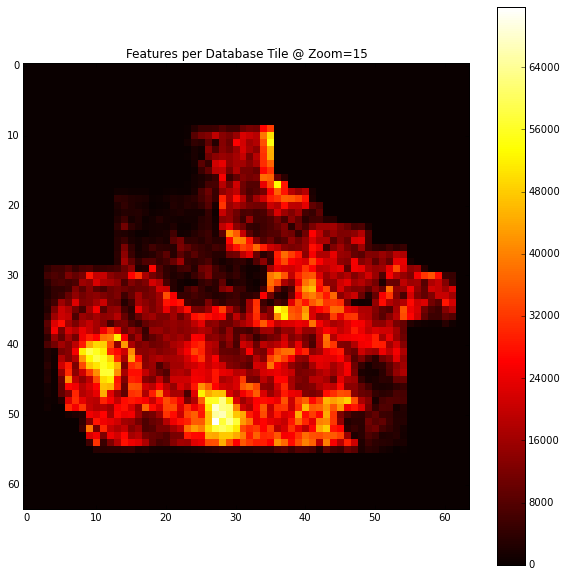

In [122]:
tidxy = np.array([unpair(tt) for tt in tid]).astype(np.int)

img = plot_on_grid(tidxy[:,0], tidxy[:,1], tidcount, xb, yb)
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='hot', interpolation='Nearest'); plt.colorbar()
plt.title('Features per Database Tile @ Zoom=15')

In [11]:
resp_500k = dbt[dbt.cols.response.index[-500000]]['response']
rows = dbt.read_where('response >= resp_500k')

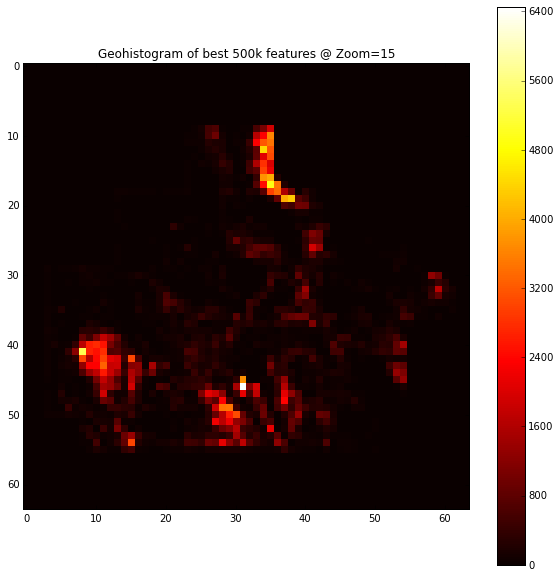

In [123]:
gid, gidcount = np.unique(rows['pair_id'], return_counts=True)
gidxy = np.array([unpair(tt) for tt in gid]).astype(np.int)
img = plot_on_grid(gidxy[:,0], gidxy[:,1], gidcount, xb, yb)
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='hot', interpolation='Nearest'); plt.colorbar()
plt.title('Geohistogram of best 500k features @ Zoom=15')

In [124]:
feature_loader = np.zeros((5, 64, 64))
zoom_cnt = 0
for zoom_depth in np.arange(11, 16):
    leaf_gen = neoextent.get_children_at_zoom(extent, zoom_depth)
    leaves = [leaf for leaf in leaf_gen]
    N = neoextent.calc_num_feat_per_child(extent, zoom_depth, 500E3)
    feat_per_leaf = np.array([leaf.num_feat_in_extent for leaf in leaves])
    geo_rows = []
    for leaf in leaves:
        geo_rows.append(load_features_by_extent(dbt, leaf, N))
    geo_rows = np.hstack([gr for gr in geo_rows if gr is not None])
    gid, gidcount = np.unique(geo_rows['pair_id'], return_counts=True)
    gidxy = np.array([unpair(tt) for tt in gid]).astype(np.int)
    feature_loader[zoom_cnt] = plot_on_grid(gidxy[:,0], gidxy[:,1], gidcount, xb, yb)
    zoom_cnt += 1

KeyboardInterrupt: 

In [133]:
fd = np.load('/Users/venabled/catkin_ws/data/neogeo/feature_loader.npy')
feature_loader = np.zeros((6,64,64))
feature_loader[0] = img
feature_loader[1:] = np.copy(fd)


In [145]:
def animate(img_num):
    """ Get whatever """
    global feature_loader
    oimg.set_array(feature_loader[img_num])
    zoom_depth = 9 + img_num
    num_div = 2**(img_num) + 1
    majorLocator = FixedLocator(np.linspace(-0.5, 63.5, num_div))
    ax.xaxis.set_major_locator(majorLocator)
    ax.yaxis.set_major_locator(majorLocator)
    oimg.autoscale()
    plt.grid(b=True, which='major', axis='both', color='r', linestyle='-', linewidth=1)
    oimg.get_axes().title.set_text('Geohistogram of best 500k from Quadtree at Depth=%d' % zoom_depth)
    return oimg, title 


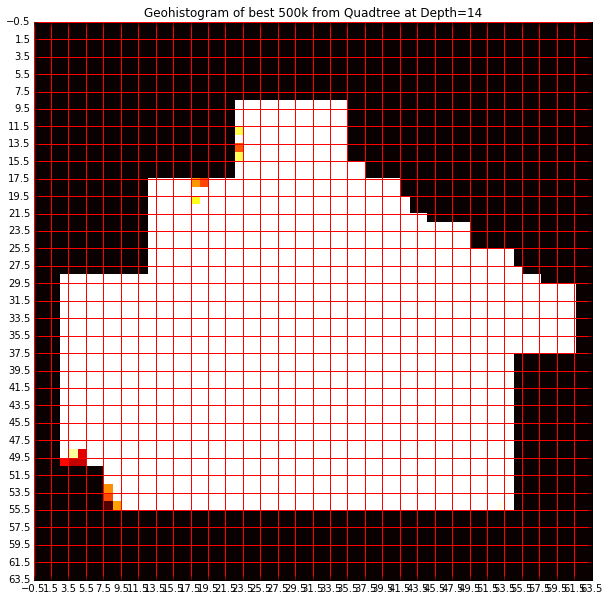

In [146]:
img_num = 2
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
oimg = ax.imshow(feature_loader[img_num], cmap='hot', interpolation='Nearest')
oimg.set_clim(0, feature_loader.max())
num_div = 2**(img_num)
majorLocator = FixedLocator(np.linspace(0, 64, num_div))
ax.xaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_locator(majorLocator)
plt.grid(b=True, which='major', axis='both', color='r', linestyle='-', linewidth=1)
oimg.get_axes().title.set_text('Geohistogram of best 500k from Quadtree at Depth=%d' % zoom_depth)
ani = animation.FuncAnimation(fig, animate, interval=1, frames=feature_loader.shape[0])
ani.save('feature_loader.gif', writer='imagemagick', fps=0.5)



In [142]:
np.linspace(-0.5, 63.5, 5)

array([ -0.5,  15.5,  31.5,  47.5,  63.5])